In [1]:
!pip install timm scikit-learn matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import time
import os
import copy
import glob
import timm
from tqdm import tqdm
from google.colab import drive

In [3]:
# --- Mount Google Drive ---
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Configuration ---
# !!! IMPORTANT: Please UPDATE these paths to YOUR Google Drive locations Or Local Paths !!!
base_drive_path = r'/content/drive/My Drive/Colab Notebooks/Chess Piece Recognition' # Main folder for this project in your Drive -> Replace with your actual path

index_files_dir = os.path.join(base_drive_path, 'colab_generated_index_files') # UPDATE THIS TO YOUR SPECIFIC PATH
model_dir = os.path.join(base_drive_path, 'EfficientNet_model') # Directory to save models and checkpoints
os.makedirs(model_dir, exist_ok=True)

checkpoint_path = os.path.join(model_dir, 'latest_checkpoint.pth') # For resuming training
best_model_save_path = os.path.join(model_dir, 'best_model_efficientnet_b0.pth') # For the overall best model

num_classes = 13
batch_size = 32
num_epochs = 25 # Total number of epochs you want to train for
learning_rate = 0.001
image_size = 500

In [5]:
# --- Classes ---
ALL_CLASSES = sorted(['bB', 'bK', 'bN', 'bP', 'bQ', 'bR', 'empty', 'wB', 'wK', 'wN', 'wP', 'wQ', 'wR'])
class_to_idx = {cls_name: i for i, cls_name in enumerate(ALL_CLASSES)}
idx_to_class = {i: cls_name for i, cls_name in enumerate(ALL_CLASSES)}

if num_classes != len(ALL_CLASSES):
    raise ValueError(f"Mismatch in num_classes ({num_classes}) and detected ALL_CLASSES ({len(ALL_CLASSES)}).")

# --- Device Configuration ---
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Data Augmentation and Normalization ---
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size + 32),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_size + 32),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Custom Dataset Class ---
class ChessPieceTextFileDataset(Dataset):
    def __init__(self, txt_files_dir, split, class_to_idx_map, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_to_idx = class_to_idx_map
        search_pattern = os.path.join(txt_files_dir, f"{split}_*.txt")
        class_txt_files = glob.glob(search_pattern)
        if not class_txt_files:
            raise FileNotFoundError(f"No text files found for split '{split}' in '{txt_files_dir}' with pattern '{search_pattern}'")
        for txt_file in class_txt_files:
            base_name = os.path.basename(txt_file)
            class_name_from_file = base_name.replace(f"{split}_", "").replace(".txt", "")
            if class_name_from_file not in self.class_to_idx:
                print(f"Warning: Class name '{class_name_from_file}' from file '{txt_file}' not in class_to_idx. Skipping.")
                continue
            label = self.class_to_idx[class_name_from_file]
            with open(txt_file, 'r') as f:
                for line in f:
                    img_path = line.strip()
                    if os.path.exists(img_path):
                        self.image_paths.append(img_path)
                        self.labels.append(label)
                    else:
                        print(f"Warning: Image path not found: {img_path} (from {txt_file})")
        if not self.image_paths:
             raise ValueError(f"No valid image paths found for split '{split}' in '{txt_files_dir}'.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"ERROR: Image file not found at {img_path}.")
            raise
        except Exception as e:
            print(f"ERROR: Could not open image {img_path}. Error: {e}")
            raise
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

Using device: cuda:0


In [6]:
# --- Load Data ---
print(f"Preparing datasets from: {index_files_dir}")
try:
    image_datasets = {
        x: ChessPieceTextFileDataset(
            txt_files_dir=os.path.join(index_files_dir, x),
            split=x,
            class_to_idx_map=class_to_idx,
            transform=data_transforms[x]
        ) for x in ['train', 'val', 'test']
    }
    num_workers_setting = 2 if device.type == 'cuda' else 0
    print(f"Using num_workers = {num_workers_setting} for DataLoaders.")
    dataloaders = {
        x: DataLoader(
            image_datasets[x],
            batch_size=batch_size,
            shuffle=(x == 'train'),
            num_workers=num_workers_setting,
            pin_memory=True if device.type == 'cuda' else False
        ) for x in ['train', 'val', 'test']
    }
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    print(f"Classes: {ALL_CLASSES}")
    print(f"Dataset sizes: Train: {dataset_sizes['train']}, Val: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")
except FileNotFoundError as e:
    print(f"Error initializing dataset (FileNotFoundError): {e}")
    exit()
except ValueError as e:
    print(f"Error initializing dataset (ValueError): {e}")
    exit()


Preparing datasets from: /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/colab_generated_index_files
Using num_workers = 2 for DataLoaders.
Classes: ['bB', 'bK', 'bN', 'bP', 'bQ', 'bR', 'empty', 'wB', 'wK', 'wN', 'wP', 'wQ', 'wR']
Dataset sizes: Train: 10400, Val: 1300, Test: 1300


In [7]:
# --- Model, Optimizer, Scheduler Setup ---
model_name = 'efficientnet_b0'
model_ft = timm.create_model(model_name, pretrained=True, num_classes=num_classes, in_chans=3)
model_ft = model_ft.to(device)

optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# --- Load Checkpoint if exists ---
start_epoch = 0
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device) # Load to current device
    model_ft.load_state_dict(checkpoint['model_state_dict'])
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
    exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1 # Start from the next epoch
    best_acc = checkpoint['best_acc']
    history = checkpoint.get('history', history) # Load history if available
    print(f"Resuming training from epoch {start_epoch}, Best Acc so far: {best_acc:.4f}")
else:
    print(f"No checkpoint found at {checkpoint_path}, starting training from scratch.")


# --- Training Loop ---
def train_model(model, criterion, optimizer, scheduler, num_total_epochs=25, current_start_epoch=0, current_best_acc=0.0, training_history=None):
    since = time.time()

    # Use loaded history or initialize if None
    if training_history is None:
        training_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # This variable will hold the weights of the model that achieved the overall best validation accuracy during this entire training process (including resumed runs)
    # It might be different from the 'best_acc' loaded from a checkpoint if a new best is found.
    overall_best_model_wts = copy.deepcopy(model.state_dict()) # Initialize with current model state
    current_overall_best_acc = current_best_acc # Initialize with loaded best_acc

    if current_start_epoch >= num_total_epochs:
        print(f"Training already completed for {num_total_epochs} epochs. Current start epoch is {current_start_epoch}.")
        # Load the best model recorded if it exists
        if os.path.exists(best_model_save_path):
            print(f"Loading best model from {best_model_save_path}")
            model.load_state_dict(torch.load(best_model_save_path, map_location=device))
        return model, training_history

    for epoch in range(current_start_epoch, num_total_epochs):
        print(f'\nEpoch {epoch+1}/{num_total_epochs}' + ' | ' + time.strftime('%H:%M:%S'))
        print('-' * 15)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            progress_bar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Epoch {epoch+1}/{num_total_epochs}", leave=True)
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                scheduler.step() # Step the scheduler after each training epoch
                training_history['train_loss'].append(epoch_loss)
                training_history['train_acc'].append(epoch_acc.item())
            else: # val phase
                training_history['val_loss'].append(epoch_loss)
                training_history['val_acc'].append(epoch_acc.item())

                # Update current_overall_best_acc if this epoch's val_acc is better
                if epoch_acc > current_overall_best_acc:
                    current_overall_best_acc = epoch_acc
                    overall_best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(overall_best_model_wts, best_model_save_path)
                    print(f"New Overall Best Model saved to {best_model_save_path} with val_acc: {current_overall_best_acc:.4f}")

                # Save checkpoint at the end of every validation epoch
                print(f"Saving latest checkpoint to {checkpoint_path} (Epoch {epoch+1}, Val Acc: {epoch_acc:.4f})")
                torch.save({
                    'epoch': epoch, # Save the completed epoch number
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_acc': current_overall_best_acc, # Save the best accuracy found so far across all runs
                    'history': training_history
                }, checkpoint_path)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s (for this session)')
    print(f'Overall Best val Acc achieved: {current_overall_best_acc:.4f}')

    # Load the weights of the overall best model before returning
    if os.path.exists(best_model_save_path): # Check if a best model was ever saved
         model.load_state_dict(torch.load(best_model_save_path, map_location=device))
    else: # Fallback if no best_model_save_path, load last overall_best_model_wts from this run
         model.load_state_dict(overall_best_model_wts)

    return model, training_history

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Loading checkpoint from: /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth
Resuming training from epoch 17, Best Acc so far: 0.9985


Starting training process...

Epoch 18/25 | 07:12:48
---------------


Train Epoch 18/25: 100%|██████████| 325/325 [23:24<00:00,  4.32s/it]


Train Loss: 0.0066 Acc: 0.9983


Val Epoch 18/25: 100%|██████████| 41/41 [02:28<00:00,  3.63s/it]


Saving latest checkpoint to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth (Epoch 18, Val Acc: 0.9977)
Val Loss: 0.0083 Acc: 0.9977

Epoch 19/25 | 07:38:42
---------------


Train Epoch 19/25: 100%|██████████| 325/325 [08:01<00:00,  1.48s/it]


Train Loss: 0.0037 Acc: 0.9991


Val Epoch 19/25: 100%|██████████| 41/41 [00:25<00:00,  1.63it/s]


Saving latest checkpoint to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth (Epoch 19, Val Acc: 0.9985)
Val Loss: 0.0085 Acc: 0.9985

Epoch 20/25 | 07:47:09
---------------


Train Epoch 20/25: 100%|██████████| 325/325 [07:57<00:00,  1.47s/it]


Train Loss: 0.0053 Acc: 0.9984


Val Epoch 20/25: 100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


Saving latest checkpoint to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth (Epoch 20, Val Acc: 0.9985)
Val Loss: 0.0085 Acc: 0.9985

Epoch 21/25 | 07:55:33
---------------


Train Epoch 21/25: 100%|██████████| 325/325 [07:53<00:00,  1.46s/it]


Train Loss: 0.0051 Acc: 0.9980


Val Epoch 21/25: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Saving latest checkpoint to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth (Epoch 21, Val Acc: 0.9985)
Val Loss: 0.0080 Acc: 0.9985

Epoch 22/25 | 08:03:54
---------------


Train Epoch 22/25: 100%|██████████| 325/325 [07:58<00:00,  1.47s/it]


Train Loss: 0.0040 Acc: 0.9990


Val Epoch 22/25: 100%|██████████| 41/41 [00:26<00:00,  1.55it/s]


Saving latest checkpoint to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth (Epoch 22, Val Acc: 0.9985)
Val Loss: 0.0079 Acc: 0.9985

Epoch 23/25 | 08:12:19
---------------


Train Epoch 23/25: 100%|██████████| 325/325 [07:59<00:00,  1.48s/it]


Train Loss: 0.0036 Acc: 0.9988


Val Epoch 23/25: 100%|██████████| 41/41 [00:26<00:00,  1.57it/s]


Saving latest checkpoint to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth (Epoch 23, Val Acc: 0.9985)
Val Loss: 0.0078 Acc: 0.9985

Epoch 24/25 | 08:20:45
---------------


Train Epoch 24/25: 100%|██████████| 325/325 [08:00<00:00,  1.48s/it]


Train Loss: 0.0039 Acc: 0.9988


Val Epoch 24/25: 100%|██████████| 41/41 [00:25<00:00,  1.60it/s]


Saving latest checkpoint to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth (Epoch 24, Val Acc: 0.9985)
Val Loss: 0.0080 Acc: 0.9985

Epoch 25/25 | 08:29:11
---------------


Train Epoch 25/25: 100%|██████████| 325/325 [07:57<00:00,  1.47s/it]


Train Loss: 0.0045 Acc: 0.9987


Val Epoch 25/25: 100%|██████████| 41/41 [00:25<00:00,  1.58it/s]


Saving latest checkpoint to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/latest_checkpoint.pth (Epoch 25, Val Acc: 0.9985)
Val Loss: 0.0077 Acc: 0.9985

Training complete in 84m 47s (for this session)
Overall Best val Acc achieved: 0.9985
Training process finished.
Training plot saved to /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/efficientnet_b0_training_plot.png

Evaluating on Test Set with the best model...
Loading best model from /content/drive/My Drive/Colab Notebooks/Chess Piece Recognition/EfficientNet_model/best_model_efficientnet_b0.pth for test evaluation.


Test Loss: 0.0097 Acc: 0.9977

Classification Report on Test Set:
              precision    recall  f1-score   support

          bB     1.0000    1.0000    1.0000       100
          bK     0.9901    1.0000    0.9950       100
          bN     1.0000    1.0000    1.0000       100
          bP     1.0000    1.0000    1.0000       100
          bQ     1.0000    1.0000    1.0000       100
          bR     1.0000    0.9900    0.9950       100
       empty     1.0000    1.0000    1.0000       100
          wB     1.0000    1.0000    1.0000       100
          wK     1.0000    0.9900    0.9950       100
          wN     1.0000    1.0000    1.0000       100
          wP     1.0000    1.0000    1.0000       100
          wQ     0.9900    0.9900    0.9900       100
          wR     0.9901    1.0000    0.9950       100

    accuracy                         0.9977      1300
   macro avg     0.9977    0.9977    0.9977      1300
weighted avg     0.9977    0.9977    0.9977      1300



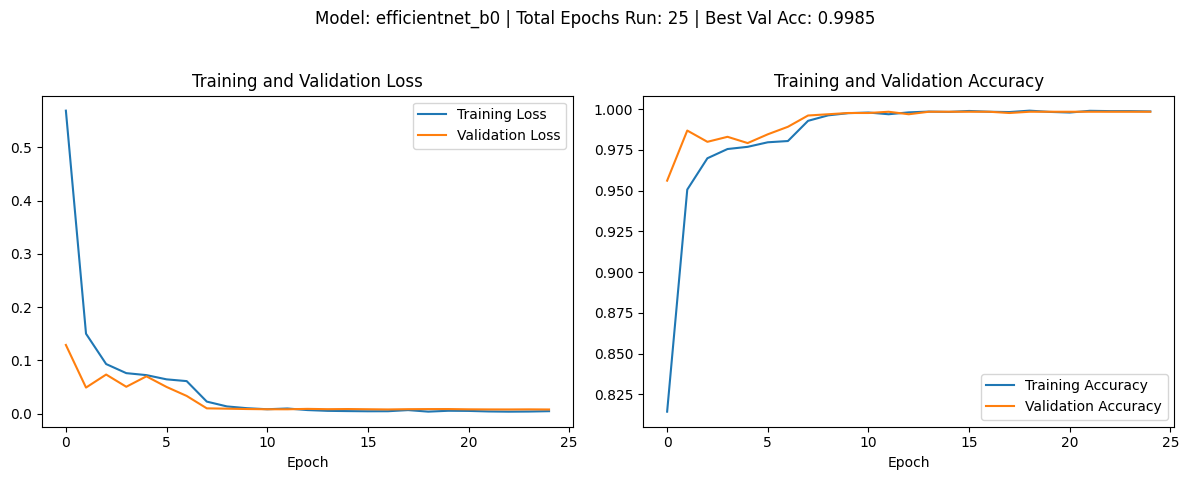

In [8]:
# --- Main Execution ---
if __name__ == '__main__':
    if not os.path.exists(index_files_dir) or \
       not os.path.exists(os.path.join(index_files_dir, 'train')) or \
       not os.path.exists(os.path.join(index_files_dir, 'val')) or \
       not os.path.exists(os.path.join(index_files_dir, 'test')):
        print(f"Error: Index files directory structure is incorrect or base path '{index_files_dir}' not found.")
    else:
        print("Starting training process...")
        criterion = nn.CrossEntropyLoss()

        model_ft_trained, final_history = train_model(
            model_ft, criterion, optimizer_ft, exp_lr_scheduler,
            num_total_epochs=num_epochs,
            current_start_epoch=start_epoch,
            current_best_acc=best_acc,
            training_history=history
        )
        print("Training process finished.")

        # Optional: Plotting
        try:
            import matplotlib.pyplot as plt
            # Adjust epochs_range if resuming: plot only up to the number of epochs actually run
            epochs_actually_run = len(final_history['train_loss'])
            epochs_plot_range = range(epochs_actually_run)

            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            if final_history['train_loss']: plt.plot(epochs_plot_range, final_history['train_loss'], label='Training Loss')
            if final_history['val_loss']: plt.plot(epochs_plot_range, final_history['val_loss'], label='Validation Loss')
            plt.legend(loc='upper right'); plt.title('Training and Validation Loss'); plt.xlabel('Epoch')

            plt.subplot(1, 2, 2)
            if final_history['train_acc']: plt.plot(epochs_plot_range, final_history['train_acc'], label='Training Accuracy')
            if final_history['val_acc']: plt.plot(epochs_plot_range, final_history['val_acc'], label='Validation Accuracy')
            plt.legend(loc='lower right'); plt.title('Training and Validation Accuracy'); plt.xlabel('Epoch')

            # Use the best accuracy loaded or found during this run for the title
            final_best_val_acc = 0.0
            if final_history['val_acc']: # Check if val_acc list is not empty
                 final_best_val_acc = max(final_history['val_acc'])

            plt.suptitle(f'Model: {model_name} | Total Epochs Run: {epochs_actually_run} | Best Val Acc: {final_best_val_acc:.4f}')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plot_save_path = os.path.join(model_dir, f"{model_name}_training_plot.png")
            plt.savefig(plot_save_path)
            print(f"Training plot saved to {plot_save_path}")
        except ImportError:
            print("Matplotlib not found. Skipping plotting.")
        except Exception as e:
            print(f"Error during plotting: {e}")

        # --- Evaluation on Test Set (using the overall best model) ---
        if dataset_sizes.get('test', 0) > 0:
            print("\nEvaluating on Test Set with the best model...")
            # Ensure the best model is loaded for evaluation
            if os.path.exists(best_model_save_path):
                print(f"Loading best model from {best_model_save_path} for test evaluation.")
                model_ft_trained.load_state_dict(torch.load(best_model_save_path, map_location=device))

            model_ft_trained.eval()
            test_running_corrects = 0; test_running_loss = 0.0
            all_preds, all_labels = [], []
            progress_bar_test = tqdm(dataloaders['test'], desc="Testing", leave=False)
            with torch.no_grad():
                for inputs, labels in progress_bar_test:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model_ft_trained(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    test_running_loss += loss.item() * inputs.size(0)
                    test_running_corrects += torch.sum(preds == labels.data)
                    all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            test_loss = test_running_loss / dataset_sizes['test']
            test_acc = test_running_corrects.double() / dataset_sizes['test']
            print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
            try:
                from sklearn.metrics import classification_report
                print("\nClassification Report on Test Set:")
                target_names = [idx_to_class[i] for i in range(num_classes)]
                print(classification_report(all_labels, all_preds, target_names=target_names, digits=4, zero_division=0))
            except ImportError:
                print("scikit-learn not found. Skipping classification report.")
            except Exception as e:
                print(f"Error generating classification report: {e}")
        else:
            print("\nNo test data found or test dataset is empty. Skipping evaluation on test set.")